In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from google.colab import drive, files
drive.mount('/content/drive')
rootpath = '/content/drive/Shareddrives/KW phase1 repo'

Mounted at /content/drive


In [2]:
import sys
sys.path.append(rootpath+'/package')
from utils.env_sdp_realRSS import env
from model.qagent import QAgent
from service.measurerss import measureRSS
from model.pathlossmodel import PathLossModel, NoiseMaker

In [3]:
import csv
import pickle
import numpy as np
from scipy.special import comb, perm
from itertools import combinations
from service.combinationset import combinationSet
from model.uav import UAV
import keras

In [48]:
pick = 1
threshold = 0.0063909353+0.36433458
# threshold = 0.0274736490+0.014038599*2

In [49]:
# load vae model
savePath = '/content/drive/Shareddrives/KW phase1 repo/datas/anomalySDPResult/0906_realRSS_10-26'
modelPath = rootpath+"/datas/trainingModelReal/VAENoanchorModel_200sample_7UAV_4uUAV_1630915603670"
vae = keras.models.load_model(modelPath, custom_objects={'latent_dim': env.latent_dim, 'epsilon_std': env.epsilon_std})

import pickle as dill
_UAVsSamples = {}
iSample = 0
with open(savePath + "/UAVsSamples_pick{}_300.npy".format(pick), 'rb') as f:
  while True:
    if iSample >= env.LOAD_SAMPLES_FOR_AE:
       break
    try:
      _UAVsSamples[iSample] = dill.load(f)
      iSample += 1
    except EOFError:
      break
UAVsSamples = _UAVsSamples

# load parsed UAVSamples
# f = open(savePath+"/shiftUAVSamples.pkl", "rb")
# _UAVsSamples = pickle.load(f)
# UAVsSamples = {}
# iSample = 0
# while True:
#   if iSample >= env.LOAD_SAMPLES_FOR_AE:
#     break
#   try:
#     UAVsSamples[iSample] = _UAVsSamples[iSample]
#     iSample += 1
#   except EOFError:
#     break
print(len(UAVsSamples))
print(UAVsSamples)


100
{0: {'ESP01': <model.uav.UAV object at 0x7f4a96127710>, 'ESP02': <model.uav.UAV object at 0x7f4a82ff5310>, 'ESP03': <model.uav.UAV object at 0x7f4a94be9350>, 'ESP04': <model.uav.UAV object at 0x7f4a887c0f90>, 'ESP05': <model.uav.UAV object at 0x7f4a9229d1d0>, 'ESP06': <model.uav.UAV object at 0x7f4a88807810>, 'ESP07': <model.uav.UAV object at 0x7f4a82b48510>, 'ESP08': <model.uav.UAV object at 0x7f4a94cc1950>, 'ESP09': <model.uav.UAV object at 0x7f4a94cc1110>, 'ESP10': <model.uav.UAV object at 0x7f4a94cafb90>, 'ESP11': <model.uav.UAV object at 0x7f4a94cafed0>}, 1: {'ESP01': <model.uav.UAV object at 0x7f4a94ca8f10>, 'ESP02': <model.uav.UAV object at 0x7f4a94caf8d0>, 'ESP03': <model.uav.UAV object at 0x7f4a94caf9d0>, 'ESP04': <model.uav.UAV object at 0x7f4a94caf350>, 'ESP05': <model.uav.UAV object at 0x7f4a94cafdd0>, 'ESP06': <model.uav.UAV object at 0x7f4a94caf710>, 'ESP07': <model.uav.UAV object at 0x7f4a94caf190>, 'ESP08': <model.uav.UAV object at 0x7f4a94caff10>, 'ESP09': <model.u

In [50]:
pathLossModel = PathLossModel()
pathLossModel.noiseMaker = NoiseMaker(mean = env.noiseMean, deviation = env.noiseDeviation)

In [51]:
groupListSamples = combinationSet(UAVsSamples)
SizeOfGroupsCombination = 0
for INumberOfCombination, GroupsOfConbination  in groupListSamples[0].items():
  for IConbination in GroupsOfConbination:
    SizeOfGroupsCombination+=1

In [ ]:
# f = open(savePath+"/shiftRawDatas.pkl", "rb")
# rawDatas = pickle.load(f)
# rawDatas = np.array(rawDatas).transpose((1,2,0,3))
# print(rawDatas.shape)
# PositionOfTargetsUAVOfGroupOfSample = rawDatas

In [52]:
_sdpResultsDatas = []
for j in range(env.N_ngps):
  with open(savePath +"/test_position{}_pickerror{}_300.csv".format(j,pick), "r") as _csv:
    csvReader = list (csv.reader(_csv, delimiter=',', quoting=csv.QUOTE_NONNUMERIC))
    print(len(csvReader))
    _sdpResultsDatas.append(csvReader)
ShapeOfSDPResultsData = np.array(_sdpResultsDatas).shape
print(np.array(_sdpResultsDatas).shape)
sdpResultsDatas = np.array(_sdpResultsDatas).reshape(env.N_ngps,ShapeOfSDPResultsData[1]//SizeOfGroupsCombination,SizeOfGroupsCombination,env.DIMENSION)
PositionOfTargetsUAVOfGroupOfSample = sdpResultsDatas.transpose((1,2,0,3))
np.array(PositionOfTargetsUAVOfGroupOfSample).shape
PositionOfTargetsUAVOfGroupOfSample = PositionOfTargetsUAVOfGroupOfSample

5800
5800
5800
5800
(4, 5800, 3)


In [53]:
PositionOfTargetsUAVOfGroupOfSample.shape

(200, 29, 4, 3)

In [54]:
from service.combinationset import groupingFromSet
from model.sdp import calculateSDP
states = {}
currentSdpResultsDatas = {}
groupLists = combinationSet(UAVsSamples)
for iSample in UAVsSamples:
  currentSdpResultsDatas[iSample]= {}
  states[iSample] = []
  for s, groupList in groupLists[iSample].items():
    for group in groupList:
      states[iSample].append(group)
  for iState, state in enumerate(states[iSample]):
    groupOfState = groupingFromSet(state)  
    currentSdpResultsDatas[iSample][iState] = []  
    for iNumberOfGroup in groupOfState:
      if len(groupOfState[iNumberOfGroup]) > 0:
        for group in groupOfState[iNumberOfGroup]:
          if group in states[iSample]:
            indexOfGroup = states[iSample].index(group)
            currentSdpResultsDatas[iSample][iState].append(PositionOfTargetsUAVOfGroupOfSample[iSample][indexOfGroup])

In [55]:
from itertools import combinations
allEstimateGroups = {}
states = {}
for iSample in UAVsSamples:
  allEstimateGroups[iSample] = {}
  UAVsSample = UAVsSamples[iSample]
  groupListSample = combinationSet({0:UAVsSample})[0]

  states[iSample] = []
  for s, groupList in groupListSample.items():
    for group in groupList:
      states[iSample].append(group)

  for iState, state in enumerate(states[iSample]):
    # print(len(state),len(state)-(env.DIMENSION+1))
    for kickNumber in range(len(state)-(env.DIMENSION+1)):
      for ikick in range(kickNumber+1):
        estimateGroups = list(combinations(state,len(state)-ikick))
        allEstimateGroups[iSample][iState] = estimateGroups

In [56]:
MSE = lambda x,y: np.mean(np.square(np.array(x)-np.array(y)), axis=1)

In [57]:
sdpOfSubGroupOfState= {} # state > index in estimateGroup > sdp
for iSample in UAVsSamples:
  sdpOfSubGroupOfState[iSample]= {}
  pathLossModel = PathLossModel()
  for iEstimateGroups in allEstimateGroups[iSample]:
    sdpOfSubGroup = {}
    sdpResultsDatas = None
    rawDatas = []
    ReadSampleSize = 1
    estimateGroups = list(map(list, allEstimateGroups[iSample][iEstimateGroups]))
    groupSize = np.array(estimateGroups).shape[0]
    for iEstimateGroup, estimateGroup in enumerate(estimateGroups):
      stateIndex = states[iSample].index(estimateGroup)
      sdpOfSubGroup[iEstimateGroup] = currentSdpResultsDatas[iSample][stateIndex]
    sdpOfSubGroupOfState[iSample][iEstimateGroups] = sdpOfSubGroup

In [58]:
from progressbar import *
widgets = ['Progress: ',Percentage(), ' ', Bar('█'),' ', Timer(),
      ' ', ETA(), ' ', FileTransferSpeed()]
pbar = ProgressBar(widgets=widgets, maxval=len(UAVsSamples)).start()

vaeOutputs = {}
normalizeVAETestingDatas = {}
DATAMIN = -3.9510938431348284
DATAMAX = 26.596492222686464
for iSample in UAVsSamples:
  pbar.update(iSample)
  # print("iSample",iSample)
  vaeOutputs[iSample] = []
  normalizeVAETestingDatas[iSample] = []
  for iState in allEstimateGroups[iSample]:
    estimateGroups = []    
    for iEstimateGroup, estimateGroup in enumerate(allEstimateGroups[iSample][iState]):
      estimateGroups.append(estimateGroup)
    dualGroupingTestingData = []
    for groupOfI in estimateGroups:
      for groupOfJ in estimateGroups:
        indexOfSubGroupInStateOfI = allEstimateGroups[iSample][iState].index(groupOfI)
        indexOfSubGroupInStateOfJ = allEstimateGroups[iSample][iState].index(groupOfJ)
        firstTrainingPickGroupData = np.array(sdpOfSubGroupOfState[iSample][iState][indexOfSubGroupInStateOfI]).copy().tolist()
        secondTrainingPickGroupData = np.array(sdpOfSubGroupOfState[iSample][iState][indexOfSubGroupInStateOfJ]).copy().tolist()
        # list (map(lambda i: firstTrainingPickGroupData.append(np.array(anchors[iSample][i].observedPosition).reshape(1,3)), range(env.N_gps)))
        # list (map(lambda i: secondTrainingPickGroupData.append(np.array(anchors[iSample][i].observedPosition).reshape(1,3)), range(env.N_gps)))
        dualGroupingTestingData.append([firstTrainingPickGroupData, secondTrainingPickGroupData])
    dualGroupingTestingData = np.array(dualGroupingTestingData).astype('float32')  
    VAETestingData = dualGroupingTestingData.reshape(len(dualGroupingTestingData), np.prod(dualGroupingTestingData.shape[1:]))
    # VAETestingData = dualGroupingTestingData.reshape((dualGroupingTestingData.shape[0],
    #       dualGroupingTestingData.shape[3],
    #       dualGroupingTestingData.shape[1],
    #       dualGroupingTestingData.shape[4],
    #       dualGroupingTestingData.shape[2]))   
    data_min = DATAMIN
    data_max = DATAMAX
    normalizeVAETestingData = (VAETestingData-data_min)/(data_max - data_min)
    normalizeVAETestingData = normalizeVAETestingData.astype('float32')
    # print(np.array(normalizeVAETestingData).shape)
    vaeOutput = vae.predict(normalizeVAETestingData, batch_size = 2048*4)
    vaeOutputs[iSample].append(vaeOutput)
    normalizeVAETestingDatas[iSample].append(normalizeVAETestingData)
pbar.finish()

Progress: 100% |███████████████| Elapsed Time: 0:01:57 Time:  0:01:57   0.9 B/s


In [59]:
f = open(savePath + "/VAE_vaeOutputs_pick{}.pkl".format(pick), "wb")
pickle.dump(vaeOutputs, f)
f.close()

f = open(savePath + "/VAE_normalizeVAETestingDatas_pick{}.pkl".format(pick), "wb")
pickle.dump(normalizeVAETestingDatas, f)
f.close()

In [38]:
f = open(savePath + "/VAE_vaeOutputs_pick{}.pkl".format(pick), "rb")
vaeOutputs = pickle.load(f)
f.close()
f = open(savePath + "/VAE_normalizeVAETestingDatas_pick{}.pkl".format(pick), "rb")
normalizeVAETestingDatas = pickle.load(f)
f.close()

In [60]:
optimalMSE = {}
optimalMSEGroup = {}
def runVAEOutput(iSample):
  print("iSample",iSample)
  _optimalMSE = []
  _optimalMSEGroup = []
  UAVsSample = UAVsSamples[iSample]
  
  for iState in allEstimateGroups[iSample]:
    try:
      mse = MSE(vaeOutputs[iSample][iState], normalizeVAETestingDatas[iSample][iState])
      # if iState %10 == 0:
        # print("iState:",iSample,iState)
      _optimalMSE.append(mse)
      _optimalMSEGroup.append(states[iSample][iState])
    except:
      continue    
  optimalMSE[iSample] = _optimalMSE
  optimalMSEGroup[iSample] = _optimalMSEGroup
  print("finish")
for iSample in UAVsSamples:
  runVAEOutput(iSample)

iSample 0
finish
iSample 1
finish
iSample 2
finish
iSample 3
finish
iSample 4
finish
iSample 5
finish
iSample 6
finish
iSample 7
finish
iSample 8
finish
iSample 9
finish
iSample 10
finish
iSample 11
finish
iSample 12
finish
iSample 13
finish
iSample 14
finish
iSample 15
finish
iSample 16
finish
iSample 17
finish
iSample 18
finish
iSample 19
finish
iSample 20
finish
iSample 21
finish
iSample 22
finish
iSample 23
finish
iSample 24
finish
iSample 25
finish
iSample 26
finish
iSample 27
finish
iSample 28
finish
iSample 29
finish
iSample 30
finish
iSample 31
finish
iSample 32
finish
iSample 33
finish
iSample 34
finish
iSample 35
finish
iSample 36
finish
iSample 37
finish
iSample 38
finish
iSample 39
finish
iSample 40
finish
iSample 41
finish
iSample 42
finish
iSample 43
finish
iSample 44
finish
iSample 45
finish
iSample 46
finish
iSample 47
finish
iSample 48
finish
iSample 49
finish
iSample 50
finish
iSample 51
finish
iSample 52
finish
iSample 53
finish
iSample 54
finish
iSample 55
finish
iS

In [61]:
# loadanomaly = np.load(rootpath+"/datas/anomalySDPResult"+"/0706/anomalyUAVs_pick1div{}_300.npy".format(40),allow_pickle=True)
import pickle as dill
anomalyUAVs = []
with open(savePath + "/anomalyUAVs_pick{}_300.npy".format(pick), 'rb') as f:
  while True:
    try:
      anomalyUAVs.append(dill.load(f))
    except EOFError:
      break
print(anomalyUAVs)

[[9], [2], [8], [5], [2], [8], [3], [2], [1], [1], [3], [9], [7], [5], [1], [6], [10], [3], [1], [2], [8], [11], [11], [9], [9], [2], [4], [11], [3], [8], [11], [4], [6], [11], [6], [7], [9], [11], [6], [2], [7], [4], [11], [11], [9], [10], [1], [6], [10], [6], [8], [11], [7], [8], [10], [2], [6], [10], [1], [8], [2], [1], [1], [2], [10], [7], [5], [10], [1], [4], [11], [3], [2], [10], [4], [1], [10], [5], [1], [8], [3], [6], [10], [10], [8], [4], [5], [9], [4], [7], [8], [6], [7], [11], [6], [9], [7], [1], [9], [11], [9], [4], [6], [8], [9], [4], [8], [7], [11], [1], [7], [10], [10], [3], [1], [8], [9], [5], [2], [2], [4], [1], [2], [8], [1], [3], [4], [5], [5], [5], [9], [5], [4], [6], [3], [6], [7], [2], [8], [9], [11], [10], [1], [8], [1], [5], [9], [9], [5], [5], [8], [1], [2], [7], [1], [5], [11], [5], [3], [4], [6], [4], [2], [3], [5], [7], [2], [5], [7], [10], [6], [7], [7], [11], [4], [8], [6], [1], [1], [11], [6], [8], [6], [2], [8], [9], [1], [1], [10], [1], [7], [7], [7], [

optimalGroup  2 : ['ESP01', 'ESP03', 'ESP04', 'ESP06', 'ESP11'] 0.01702321 0.0
optimalGroup  19 : ['ESP03', 'ESP06', 'ESP09', 'ESP10', 'ESP11'] 0.016194718 0.0
optimalGroup  17 : ['ESP03', 'ESP04', 'ESP06', 'ESP10', 'ESP11'] 0.015735442 0.0
optimalGroup ['ESP03', 'ESP04', 'ESP06', 'ESP10', 'ESP11']
anomalyUAVs [9]
optimalGroup  9 : ['ESP01', 'ESP02', 'ESP07', 'ESP09', 'ESP11'] 0.009894571 0.0
optimalGroup  15 : ['ESP02', 'ESP05', 'ESP06', 'ESP07', 'ESP09'] 0.006667476 0.0
optimalGroup  19 : ['ESP02', 'ESP06', 'ESP07', 'ESP09', 'ESP11'] 0.006547238 0.0
optimalGroup ['ESP02', 'ESP06', 'ESP07', 'ESP09', 'ESP11']
anomalyUAVs [2]
optimalGroup  19 : ['ESP03', 'ESP05', 'ESP06', 'ESP07', 'ESP08'] 0.010314929 0.0
optimalGroup  8 : ['ESP02', 'ESP03', 'ESP05', 'ESP07', 'ESP08'] 0.009200288 0.0
optimalGroup  0 : ['ESP02', 'ESP03', 'ESP04', 'ESP05', 'ESP06'] 0.007690528 0.0
optimalGroup ['ESP02', 'ESP03', 'ESP04', 'ESP05', 'ESP06']
anomalyUAVs [8]
optimalGroup  18 : ['ESP02', 'ESP04', 'ESP06', 'ESP

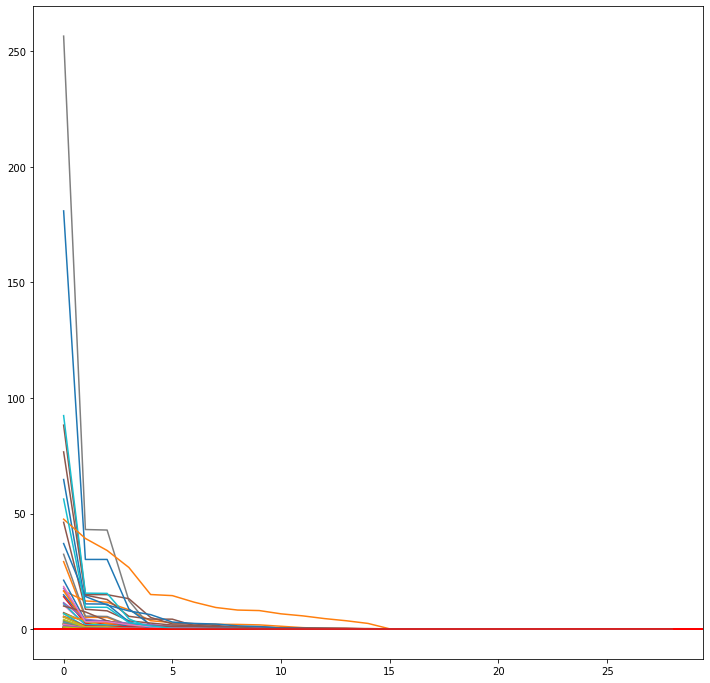

In [62]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(1,1, figsize = (12,12))
aggregateMSE = {}
# threshold = 0.065+0.025
for iSample in UAVsSamples:
  aggregateMSE[iSample] ={}  
  sortIndex = sorted(range(len(optimalMSE[iSample])), key=lambda k: np.mean(optimalMSE[iSample][k]), reverse=True)
  sortOptionalMSE = [np.mean(optimalMSE[iSample][i]) for i in sortIndex]
  for i in sortIndex[-3:]:
    print("optimalGroup ",i,":",optimalMSEGroup[iSample][i],np.mean(optimalMSE[iSample][i]),np.std(optimalMSE[iSample][i]))
  aggregateMSE[iSample] = []
  for i in range(len(optimalMSE[iSample])):
    aggregateMSE[iSample].append(np.mean(optimalMSE[iSample][i]))
  index = np.argmin(aggregateMSE[iSample])
  print("optimalGroup",optimalMSEGroup[iSample][index])
  print("anomalyUAVs",anomalyUAVs[iSample])
  # print("anomalyUAVs",anomalyUAVs[iSample])
  ax1.plot(sortOptionalMSE[-50:])
  ax1.axhline(y = threshold, color = 'r', linestyle = '-')
  plt.grid()


1
[5.86664158e-03 1.00805588e-02 1.36237862e-02 1.70939022e-02
 2.06336424e-02 2.45758756e-02 2.88721553e-02 3.26178572e-02
 3.64148379e-02 4.06090932e-02 4.42797758e-02 4.77076347e-02
 5.23237304e-02 5.68516017e-02 8.19452632e-02 1.05732043e-01
 1.22427907e-01 1.46335449e-01 1.74660830e-01 2.17935643e-01
 2.55186730e-01 3.00214306e-01 3.80120291e-01 4.63080148e-01
 6.50614241e-01 1.29594854e+00 2.43981364e+00 2.88446543e+00
 9.72106320e+00] [7.81884583e-03 1.16486832e-02 1.48450774e-02 1.79613985e-02
 2.14210778e-02 2.46971199e-02 2.86230484e-02 3.30216589e-02
 3.56377519e-02 3.89680290e-02 4.31716250e-02 4.70731574e-02
 5.15772309e-02 5.61527532e-02 8.59027983e-02 9.43556912e-02
 1.24284080e-01 1.49878395e-01 1.73511672e-01 2.14301508e-01
 2.52555841e-01 2.96751013e-01 3.54198903e-01 4.86255947e-01
 6.26876236e-01 1.18795224e+00 2.53949146e+00 2.74464423e+00
 1.16504718e+01]
19.90986612775923 20.454133872240767
[14 15 16 ... 26 27 28]
1500
729


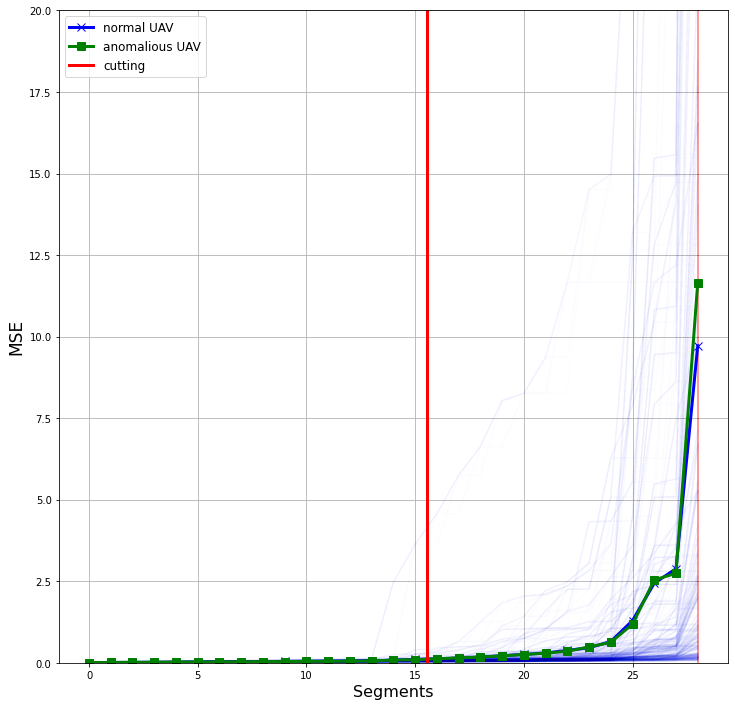

In [63]:
import matplotlib.pyplot as plt
# threshold = 0.32+0.07
print(pick)
fig, ax1 = plt.subplots(1,1, figsize = (12,12))
sumY = np.zeros(len(optimalMSE[0]))
sumAnomalyY = np.zeros(len(optimalMSE[0]))
sumthreaholdIndex = []
thresholdSampleSize = 100
for iSample in UAVsSamples:
  # if not iSample < thresholdSampleSize:
  #   break
  sortIndex = sorted(range(len(optimalMSE[iSample])), key=lambda k: np.mean(optimalMSE[iSample][k]), reverse=False)
  sortOptionalMSE = [np.mean(optimalMSE[iSample][i]) for i in sortIndex]
  PDFWindowsMemberTable = {}
  anomalyId = anomalyUAVs[iSample]
  # anomalyId = []
  threaholdIndex = 0
  for iUAV,uav in UAVsSamples[iSample].items():
    if uav.observedPosition != None:
      PDFWindowsMemberTable[uav.id] = []
      # print(uav.observedPosition, uav.realPosition)
      # if uav.observedPosition != uav.realPosition:
      #   anomalyId.append(uav.id)
        # print(uav.id,uav.observedPosition,uav.realPosition,np.linalg.norm(np.array(uav.observedPosition)-np.array(uav.realPosition)))
  for i in range(0,len(sortIndex)):
    if sortOptionalMSE[i] > threshold:
      threaholdIndex = i
      sumthreaholdIndex.append(i)
      # break
  # print(WindowsMemberTable)
  for iWindows in range(0,len(sortIndex)):
    memberTable = {}
    for groupMember in optimalMSEGroup[iSample][sortIndex[iWindows]]:
      try:
        memberTable[groupMember] += sortOptionalMSE[iWindows]
      except:
        memberTable[groupMember] = sortOptionalMSE[iWindows]
    for UAVId in PDFWindowsMemberTable:
      isHaveValue = False
      for member, value in memberTable.items():
        _memberId = int(member[3:])
        if _memberId == UAVId:
          PDFWindowsMemberTable[UAVId].append(value)
          isHaveValue = True
      if not isHaveValue:
        if len(PDFWindowsMemberTable[UAVId]) > 0:
          PDFWindowsMemberTable[UAVId].append(PDFWindowsMemberTable[UAVId][-1])
        else:
          PDFWindowsMemberTable[UAVId].append(0)
  _sumY = np.zeros(len(optimalMSE[iSample]))
  _sumAnomalyY = np.zeros(len(optimalMSE[iSample]))
  for UAVId in PDFWindowsMemberTable:
    # print(UAVId, PDFWindowsMemberTable[UAVId])
    from scipy.interpolate import make_interp_spline
    x = np.arange(0,len(PDFWindowsMemberTable[UAVId]))
    y = PDFWindowsMemberTable[UAVId]
    # model=make_interp_spline(x,y)
    # xs=np.linspace(1,15,5000)
    # ys=model(xs)
    lineColor = 'b'
    if UAVId in anomalyId:
      lineColor = 'g'
    ax1.plot(x,y,linestyle='-', c=lineColor, alpha=1/(1*thresholdSampleSize))
    if UAVId in anomalyId:
      for iyv, _xv in enumerate(y):
        _sumAnomalyY[iyv] += _xv
    else:
      for iyv, _yv in enumerate(y):
        _sumY[iyv] += _yv
  sumY += _sumY/(env.N_gps - len(anomalyId))
  sumAnomalyY += _sumAnomalyY/(len(anomalyId))
    # ax1.legend()
  # ax1.plot( np.arange(0,len(sortOptionalMSE)),sortOptionalMSE[::-1])
  ax1.axvline(x=threaholdIndex,linestyle='-', c='r', alpha=1/(2*thresholdSampleSize))
  # ax1.legend()
# meanY = sumY/(thresholdSampleSize)
# meanAnomalyY = sumAnomalyY/(thresholdSampleSize)
meanY = sumY/len(UAVsSamples)
meanAnomalyY = sumAnomalyY/len(UAVsSamples)
print(meanY, meanAnomalyY)
import numpy as np, scipy.stats as st
lower,upper = st.t.interval(0.95, len(sumthreaholdIndex)-1, loc=np.mean(sumthreaholdIndex), scale=st.sem(sumthreaholdIndex))
print(lower,upper)
ax1.plot(x,meanY, label= "normal UAV",linestyle='-', c='b', linewidth=3, marker = 'x', markersize=8)
ax1.plot(x,meanAnomalyY, label= "anomalious UAV",linestyle='-', c='g', linewidth=3, marker = 's', markersize=8)
sumthreaholdIndex = np.array(sumthreaholdIndex)
print(sumthreaholdIndex)
# sumthreaholdIndex = np.array(sumthreaholdIndex)[sumthreaholdIndex >lower]
print(len(sumthreaholdIndex))
sumthreaholdIndex = sumthreaholdIndex[sumthreaholdIndex < upper]
print(len(sumthreaholdIndex))
ax1.axvline(x=np.mean(sumthreaholdIndex), label= "cutting", c='r', linewidth=3)
ax1.legend(loc='upper left', prop={'size': 12})
ax1.set_xlabel('Segments', fontsize=16)
ax1.set_ylabel('MSE', fontsize=17)
# ax1.set_title('{} div {} pick {}'.format(dataFolder.split("_")[1], div, pick))
ax1.set_ylim([0,20])
# ax1.set_xlim([0,25])
plt.grid()

# plt.savefig(rootpath+"/datas/anomalyNewSDPResult"+dataFolder+"/appearance{}_{}".format(div,pick))
# plt.savefig(rootpath+"/datas/anomalyNewSDPResult/appearanceSDSOCP{}_{}".format(div,pick))

In [64]:
# threshold = 0.065+0.025
memberTableSample = {}
for iSample in UAVsSamples:
  sortIndex = sorted(range(len(optimalMSE[iSample])), key=lambda k: np.mean(optimalMSE[iSample][k]), reverse=True)
  sortOptionalMSE = [np.mean(optimalMSE[iSample][i]) for i in sortIndex]

  memberTable = {}
  for i in sortIndex:
    if np.mean(optimalMSE[iSample][i]) < threshold:
      # print(optimalMSEGroup[iSample][i],np.mean(optimalMSE[iSample][i]),np.std(optimalMSE[iSample][i]))
      for groupMember in optimalMSEGroup[iSample][i]:
        try:
          memberTable[groupMember] += 1
        except:
          memberTable[groupMember] = 1
  memberTableSample[iSample] = memberTable
  # break
# print(memberTableSample)

memberIdSample = {}
memberAmountSample = {}
for iSample, memberTableOfSample in memberTableSample.items():
  memberId = []
  memberAmount = []
  for iMember, amount in memberTableOfSample.items():
    memberId.append(iMember)
    memberAmount.append(amount)
  memberIdSample[iSample] = memberId
  memberAmountSample[iSample] = memberAmount

In [65]:
goodUAVsSample = {}
zeroSample = []
for iSample in UAVsSamples:
  trainSum = np.sum(memberAmountSample[iSample])
  confidenceSum = trainSum*0.9//1
  # print(trainSum, confidenceSum,memberAmountSample)
  candidateUAV = []
  sortMap = sorted(memberTableSample[iSample].items(), key=lambda x:x[1], reverse=True)
  # print(iSample,sortMap)
  for i, v in sortMap:
    for _ in range(v):
      candidateUAV.append(i)
  # print(candidateUAV) 
  goodUAVID = []
  for i, v in enumerate(candidateUAV):
    if i <= confidenceSum:
      id = int(v[3:])
      if id in goodUAVID:
        continue
      else:
        goodUAVID.append(id)
  print(goodUAVID)
  if len(goodUAVID) == 0:
    zeroSample.append(iSample)
  goodUAVsSample[iSample] = goodUAVID
  # break

[11, 6, 9, 10, 4, 3]
[2, 7, 6, 1, 5, 11, 9]
[8, 4, 3, 2, 5, 6, 7]
[10, 6, 2, 4, 9, 5, 1]
[9, 10, 2, 7, 4, 3, 1]
[8, 4, 2, 5, 7, 9, 3]
[11, 3, 9, 7, 8, 1]
[2, 8, 5, 1, 6, 9, 11]
[9, 1, 10, 6, 8, 5, 7]
[4, 9, 11, 8, 7, 5, 1]
[3, 7, 9, 11, 2, 6, 10]
[6, 11, 9, 2, 5, 7]
[1, 9, 6, 8, 5, 7, 11]
[9, 10, 5, 7, 6, 1]
[1, 10, 9, 8, 11, 3, 6]
[6, 11, 4, 5, 2, 7, 10]
[3, 2, 11, 4, 8, 10, 7]
[11, 3, 4, 10, 5, 7]
[4, 2, 3, 5, 7, 1]
[2, 11, 10, 3, 5, 4, 1]
[8, 9, 5, 10, 1, 6, 4]
[11, 3, 9, 6, 2, 5, 10]
[11, 2, 10, 6, 3, 9]
[2, 4, 6, 10, 7, 9]
[10, 11, 9, 2, 4, 1, 8]
[11, 8, 3, 1, 7, 2, 4]
[4, 6, 10, 1, 9, 7, 2]
[10, 3, 4, 5, 7, 11]
[6, 11, 5, 2, 7, 8, 3]
[10, 1, 7, 9, 6, 8]
[5, 3, 4, 2, 7, 11]
[4, 9, 2, 5, 8, 11, 1]
[3, 9, 11, 4, 6, 7, 8]
[11, 6, 2, 5, 4, 10, 8]
[11, 6, 5, 8, 1, 3, 4]
[1, 2, 4, 10, 5, 8, 7]
[8, 6, 2, 3, 4, 9]
[9, 5, 11, 10, 4, 7, 8]
[6, 10, 11, 2, 3, 9]
[5, 9, 4, 2, 1, 3, 6]
[3, 11, 10, 4, 7, 2, 1]
[4, 5, 9, 1, 7, 3, 6]
[9, 7, 11, 6, 1, 8]
[3, 4, 9, 11, 6, 2, 1]
[11, 5, 6, 10, 9, 1, 

In [45]:
assert(zeroSample == [31, 34, 79, 89, 95])
# zeroSample = []

In [66]:
import pickle as dill
_anomalyUAVsSamples = {}
iSample = 0
with open(savePath +"/UAVsSamples_pick{}_300.npy".format(pick), 'rb') as f:
  while True:
    if iSample >= env.LOAD_SAMPLES_FOR_AE:
       break
    try:
      _anomalyUAVsSamples[iSample] = dill.load(f)
      iSample += 1
    except EOFError:
      break
anomalyUAVsSamples = _anomalyUAVsSamples
print(_anomalyUAVsSamples)

{0: {'ESP01': <model.uav.UAV object at 0x7f4a824783d0>, 'ESP02': <model.uav.UAV object at 0x7f4a834fee90>, 'ESP03': <model.uav.UAV object at 0x7f4a93aa38d0>, 'ESP04': <model.uav.UAV object at 0x7f4a83551ad0>, 'ESP05': <model.uav.UAV object at 0x7f4a826d0050>, 'ESP06': <model.uav.UAV object at 0x7f4a82a9e110>, 'ESP07': <model.uav.UAV object at 0x7f4a82a3d150>, 'ESP08': <model.uav.UAV object at 0x7f4a83406450>, 'ESP09': <model.uav.UAV object at 0x7f4a83406c50>, 'ESP10': <model.uav.UAV object at 0x7f4a826a94d0>, 'ESP11': <model.uav.UAV object at 0x7f4a826dfbd0>}, 1: {'ESP01': <model.uav.UAV object at 0x7f4a826a9190>, 'ESP02': <model.uav.UAV object at 0x7f4a962733d0>, 'ESP03': <model.uav.UAV object at 0x7f4a96273990>, 'ESP04': <model.uav.UAV object at 0x7f4a82a62110>, 'ESP05': <model.uav.UAV object at 0x7f4a82a62710>, 'ESP06': <model.uav.UAV object at 0x7f4a824dffd0>, 'ESP07': <model.uav.UAV object at 0x7f4a824df550>, 'ESP08': <model.uav.UAV object at 0x7f4a824df790>, 'ESP09': <model.uav.U

In [67]:
# zeroSample = []
TP = 0
for iSample in goodUAVsSample:
  if iSample not in zeroSample:
    # print(anomalyUAVs[iSample],goodUAVsSample[iSample])
    for anomlayUAV in anomalyUAVs[iSample]:
      if not anomlayUAV in goodUAVsSample[iSample] and len(goodUAVsSample[iSample]) != 0:
        TP+= 1.0

TN = 0
for iSample in goodUAVsSample:
  if iSample not in zeroSample:
   for _, uav in anomalyUAVsSamples[iSample].items():
      # print(uav.id,goodUAVsSample[iSample])
      if uav.id in goodUAVsSample[iSample] and uav.observedPosition == uav.realPosition and uav.observedPosition != None:
          TN += 1.0

FN = 0
for iSample in goodUAVsSample:
  if iSample not in zeroSample:
   for anomlayUAV in anomalyUAVs[iSample] :
      if anomlayUAV in goodUAVsSample[iSample] or len(goodUAVsSample[iSample]) == 0:
        FN += 1.0

FP = 0
for iSample in goodUAVsSample:
  if iSample not in zeroSample:
  #  for _, uav in UAVsSamples[iSample].items():
      # print(iSample,uav.id,goodUAVsSample[iSample],uav.observedPosition,uav.realPosition)
      # break
   for _, uav in anomalyUAVsSamples[iSample].items():
      if uav.id not in goodUAVsSample[iSample] and uav.observedPosition == uav.realPosition and uav.observedPosition != None:
        # print("====",iSample,uav.id,goodUAVsSample[iSample],anomalyUAVs[iSample],uav.observedPosition,uav.realPosition)
        FP += 1.0
print("TP:",(TP/len(goodUAVsSample)) *100)
print("TN:",(TN/len(goodUAVsSample))*100)
print("FP:",(FP/len(goodUAVsSample)) *100)
print("FN:",(FN/len(goodUAVsSample))*100)
print("Precision:",(TP/(FP+TP))*100)
print("Recall:",(TP/(FN+TP))*100)
p = (TP/(FP+TP))*100
r = (TP/(FN+TP))*100
print("F1 score:",2*((p*r)/(p+r)))
# f = open(rootpath+"/datas/datas_forAnomalyDetection/realDataBestAnchorsSD-SOCP/0906_100sample_{}anomaly_SelectedAnchors_VAE.pkl".format(pick), "wb")
# pickle.dump(goodUAVsSample, f)
# f.close()


TP: 0.0
TN: 566.0
FP: 34.0
FN: 100.0
Precision: 0.0
Recall: 0.0


ZeroDivisionError: ignored

### 8-20 1 anomaly

TP: 96.0

TN: 572.0

FP: 28.000000000000004

FN: 4.0

Precision: 77.41935483870968

Recall: 96.0

F1 score: 85.71428571428571

### 8-20 2 anomaly

TP: 148.0

TN: 418.0

FP: 97.0

FN: 37.0

Precision: 60.40816326530612

Recall: 80.0

F1 score: 68.83720930232559

### 10-14 1 anomaly
TP: 90.0

TN: 557.0

FP: 43.0

FN: 10.0

Precision: 67.66917293233082

Recall: 90.0

F1 score: 77.25321888412017

## 10-14 2 anomaly
TP: 142.0

TN: 450.0

FP: 65.0

FN: 43.0

Precision: 68.59903381642512

Recall: 76.75675675675676

F1 score: 72.44897959183673